In [3]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidi

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_66Agree.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_AllAgree.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/README.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/License.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_75Agree.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_50Agree.txt


In [2]:
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login

user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HFace")

login(token=secret_value_0 )

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import scipy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from datasets import Dataset
import evaluate
import warnings

warnings.filterwarnings("ignore")

2025-08-02 13:57:13.556659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754143033.782740      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754143033.841614      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv',
                 encoding='unicode_escape',
                 names=['sentiment', 'headline'])
print(df.shape, "\n")
df.head(10)

(4846, 2) 



,sentiment,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6,positive,"For the last quarter of 2010 , Componenta 's n..."
7,positive,"In the third quarter of 2010 , net sales incre..."
8,positive,Operating profit rose to EUR 13.1 mn from EUR ...
9,positive,"Operating profit totalled EUR 21.1 mn , up fro..."


In [6]:
df["headline"].nunique()

4838

So of our 4846 Headlines, 4838 are unique. Implying that there are about 8 duplicate Headlines, I'll drop these.

In [7]:
df.drop_duplicates(subset=['headline'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4838 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4838 non-null   object
 1   headline   4838 non-null   object
dtypes: object(2)
memory usage: 113.4+ KB


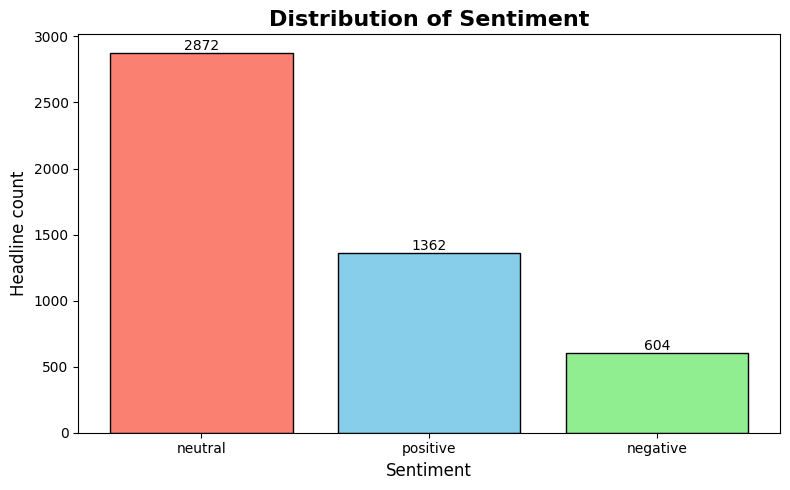

In [8]:
sentiment_counts = df['sentiment'].value_counts()
colors = ['salmon', 'skyblue', 'lightgreen']

plt.figure(figsize=(8, 5))
bars = plt.bar(
    sentiment_counts.index, 
    sentiment_counts.values, 
    color=colors, 
    edgecolor='black'
)
plt.title('Distribution of Sentiment', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Headline count', fontsize=12)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval),
             ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
def wordcount_gen(df, category=None, max_words=50, background_color='white', figsize=(8, 8)):
    """
    Generates a word cloud for a specific label or all labels in the dataframe.
    
    Parameters:
        df (pd.DataFrame): DataFrame with 'label' and 'headline' columns
        category (str or None): Specific sentiment to visualize, or None for all
        max_words (int): Maximum words in the word cloud
        background_color (str): Background color of the word cloud
        figsize (tuple): Figure size for the plot
    """
    
    sentiments = [category] if category else df['sentiment'].unique()
    
    for sentiment in sentiments:
        combined_text = " ".join(df.loc[df['sentiment'] == sentiment, 'headline'].astype(str))
        
        wc = WordCloud(
            background_color=background_color,
            max_words=max_words,
            stopwords=STOPWORDS,
            colormap='viridis'
        ).generate(combined_text)
        
        plt.figure(figsize=figsize)
        plt.imshow(wc, interpolation='bilinear')
        plt.title(f"{sentiment.capitalize()} Sentiment Word Cloud", fontsize=18, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

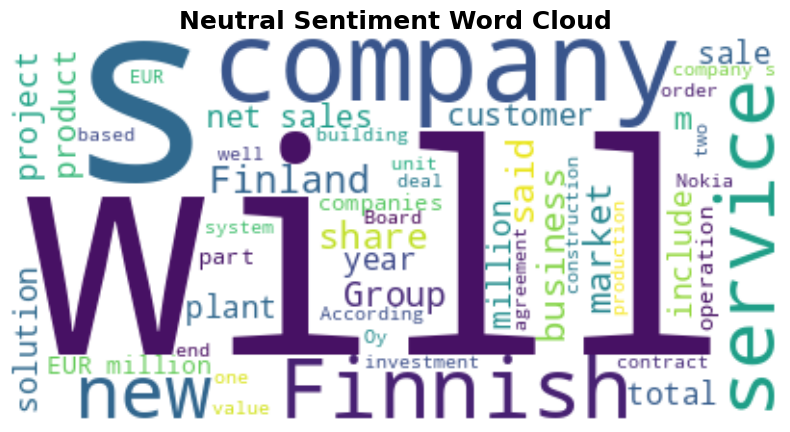

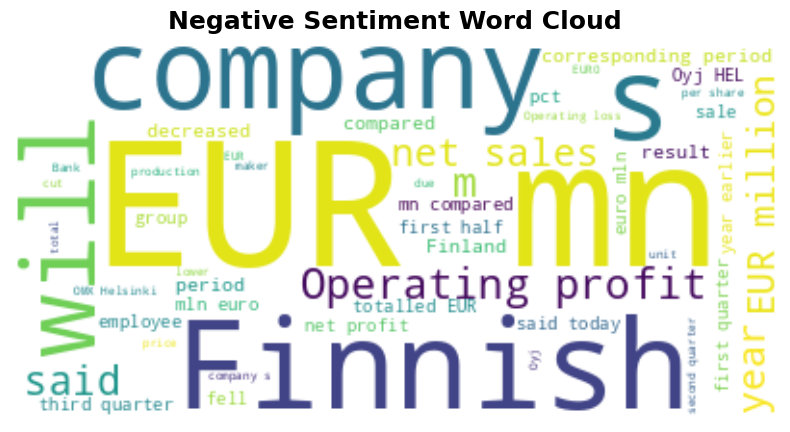

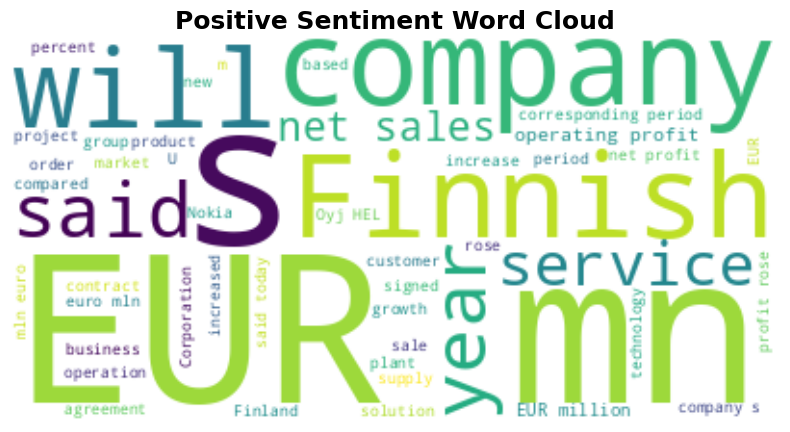

In [10]:
wordcount_gen(df)

In [11]:
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df["label"] = df["sentiment"].map(label_map).astype(int)

In [12]:
df

,sentiment,headline,label
0,neutral,"According to Gran , the company has no plans t...",1
1,neutral,Technopolis plans to develop in stages an area...,1
2,negative,The international electronic industry company ...,0
3,positive,With the new production plant the company woul...,2
4,positive,According to the company 's updated strategy f...,2
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,0
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,1
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,0
4844,negative,Net sales of the Paper segment decreased to EU...,0


In [13]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=21, stratify=df['label'])

# Then split train into train and eval
train_df, eval_df = train_test_split(train_df, test_size=0.2, random_state=21, stratify=train_df['label'])

In [14]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [15]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(eval_df)
test_dataset = Dataset.from_pandas(test_df)

# Define tokenize function
def tokenize_function(examples):
    return tokenizer(examples["headline"], padding=True, truncation=True)

# Apply to datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/2708 [00:00<?, ? examples/s]

Map:   0%|          | 0/678 [00:00<?, ? examples/s]

Map:   0%|          | 0/1452 [00:00<?, ? examples/s]

In [16]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    acc = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    
    return {
        "accuracy": acc,
        "f1": f1
    }

In [18]:
training_args = TrainingArguments(
    output_dir="financial_example",
    learning_rate=3e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    eval_strategy="epoch",        
    save_strategy="epoch",              
    logging_strategy="epoch",           
    logging_steps=10,                   
    load_best_model_at_end=True,        
    metric_for_best_model="accuracy",         
    push_to_hub_model_id="news_sentiment_classifier",
    report_to="none",                  
    disable_tqdm=False                  
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # stop if 2 bad evals
)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.981300,0.879304,0.592920,0.441396
2,0.816600,0.746399,0.679941,0.605941
3,0.684700,0.632964,0.758112,0.739205
4,0.567200,0.548274,0.793510,0.788404
5,0.482300,0.502542,0.799410,0.796338
6,0.418700,0.481743,0.802360,0.799603
7,0.376100,0.466122,0.802360,0.802178
8,0.345300,0.457991,0.809735,0.808797
9,0.320000,0.456063,0.809735,0.809321
10,0.293100,0.451241,0.814159,0.813609


TrainOutput(global_step=1275, training_loss=0.4352338155110677, metrics={'train_runtime': 289.6509, 'train_samples_per_second': 186.984, 'train_steps_per_second': 5.869, 'total_flos': 1261153521748800.0, 'train_loss': 0.4352338155110677, 'epoch': 15.0})

In [20]:
trainer.evaluate()

{'eval_loss': 0.4548383951187134,
 'eval_accuracy': 0.8200589970501475,
 'eval_f1': 0.8204922679202638,
 'eval_runtime': 1.6383,
 'eval_samples_per_second': 413.847,
 'eval_steps_per_second': 13.429,
 'epoch': 15.0}

In [21]:
# trainer.push_to_hub()

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Dugerij/news_sentiment_classifier/commit/8adffc1dec94940499d9e06b67a8ba91613f7301', commit_message='End of training', commit_description='', oid='8adffc1dec94940499d9e06b67a8ba91613f7301', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Dugerij/news_sentiment_classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='Dugerij/news_sentiment_classifier'), pr_revision=None, pr_num=None)